### Import Packages

In [1]:
import numpy as np
import pandas as pd
import json
import requests
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime
import folium
from folium import plugins

from pandas.io.json import json_normalize
%matplotlib inline

### Load 1 Year of Data

In [2]:
# startDate = "2017-01-01"
# datelist = pd.date_range(pd.to_datetime(startDate), periods=366).tolist() #1 year of data

In [3]:
# requestsDataFrame = pd.DataFrame()

# for index in range(len(datelist)-1):
#     day = str(datelist[index].date())
#     nextDay = str(datelist[index+1].date())
#     url = """https://secure.toronto.ca/webwizard/ws/requests.json?start_date=""" + day + """T00:00:00Z&end_date=""" + nextDay + """T00:00:00Z&jurisdiction_id=toronto.ca"""
#     response = requests.get(url)
#     response = json_normalize(response.json()['service_requests'])
#     assert response.shape[0] < 1000
#     requestsDataFrame = pd.concat([requestsDataFrame, response])

In [4]:
# requestsDataFrame.to_pickle("./rawData.pkl")

In [5]:
requestsDataFrame = pd.read_pickle("rawData.pkl")

### Basic data cleaning

In [6]:
requestsDataFrame.reset_index(inplace = True)
requestsDataFrame.drop(['index'], axis = 1, inplace = True)

In [7]:
requestsDataFrame.requested_datetime = pd.to_datetime(requestsDataFrame.requested_datetime).dt.date
requestsDataFrame.expected_datetime = pd.to_datetime(requestsDataFrame.expected_datetime).dt.date
requestsDataFrame.updated_datetime = pd.to_datetime(requestsDataFrame.updated_datetime).dt.date

In [8]:
#remove duplicate service_request_id's -> take latest updated datetime
rows = requestsDataFrame.groupby("service_request_id")['updated_datetime'].transform(max) == requestsDataFrame['updated_datetime']
requestsDataFrame = requestsDataFrame[rows]

In [9]:
columns = ["service_request_id", "lat", "long", "service_name", "requested_datetime", "expected_datetime",
           "updated_datetime", "status", "status_notes"]
requestsDataFrame = requestsDataFrame[columns]
requestsDataFrame = requestsDataFrame.dropna()
requestsDataFrame = requestsDataFrame.drop_duplicates()

### Assertions

In [11]:
#check if no duplicate service_request_id's
assert requestsDataFrame.shape[0] == len(requestsDataFrame['service_request_id'].unique())

In [12]:
# Ensure number of days == 365
assert len(pd.to_datetime(requestsDataFrame.requested_datetime).dt.date.unique()) == 365

### EDA

In [ ]:
pd.DataFrame(requestsDataFrame.groupby('service_name')['service_name'].agg(len))

In [37]:
pd.DataFrame(requestsDataFrame.groupby('service_name')['service_name'].agg(len))

,service_name
service_name,
Bridge - Graffiti Complaint,349
Graffiti,2120
Litter / Bin / Graffiti on Bin,22
Road - Graffiti Complaint,111
Road - Pot hole,11489
Sidewalk - Graffiti Complaint,284


In [47]:
pd.DataFrame(requestsDataFrame.groupby(['service_name', 'status'])['status'].agg(len))

status
service_name                   status        
Bridge - Graffiti Complaint    closed     349
Graffiti                       closed    2088
                               open        32
Litter / Bin / Graffiti on Bin closed      22
Road - Graffiti Complaint      closed     111
Road - Pot hole                closed   11321
                               open       168
Sidewalk - Graffiti Complaint  closed     278
                               open         6

In [35]:
pd.DataFrame(requestsDataFrame.groupby('status_notes')['status_notes'].agg(len))

,status_notes
status_notes,
"Cancelled - The request may be a duplicate, work is previously scheduled or no work is required.",363
Completed - The request has been concluded.,13806
In progress - The request has been scheduled.,30
"In progress - The request is being investigated, assessed and/or responded to; additional work may be required, if applicable.",176


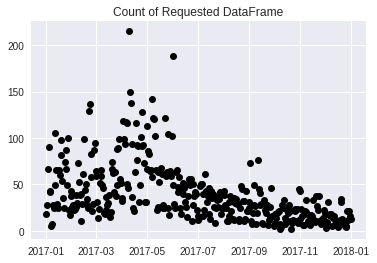

In [34]:
#Count of Requested Date
requestedDate = pd.DataFrame(requestsDataFrame.groupby(['requested_datetime'])['requested_datetime'].agg(len))
fig, ax = plt.subplots()
ax.plot(requestedDate['requested_datetime'].index, requestedDate['requested_datetime'].values,'o', color='black')
ax.set_title('Count of Requested DataFrame')

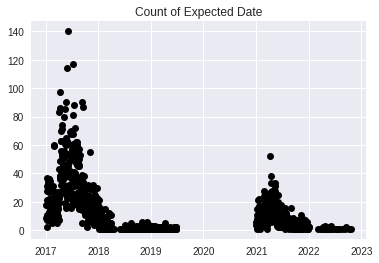

In [33]:
#Count of Expected Date
expectedDate = pd.DataFrame(requestsDataFrame.groupby(['expected_datetime'])['expected_datetime'].agg(len))
fig, ax = plt.subplots()
ax.plot(expectedDate['expected_datetime'].index, expectedDate['expected_datetime'].values,'o', color='black')
ax.set_title('Count of Expected Date')

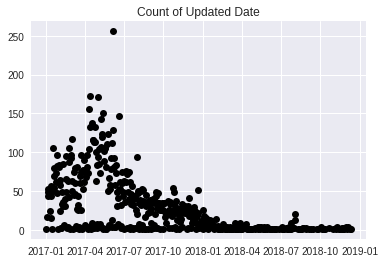

In [32]:
#Count of Updated Date
updatedDate = pd.DataFrame(requestsDataFrame.groupby(['updated_datetime'])['updated_datetime'].agg(len))
fig, ax = plt.subplots()
ax.plot(updatedDate['updated_datetime'].index, updatedDate['updated_datetime'].values,'o', color='black')
ax.set_title('Count of Updated Date')

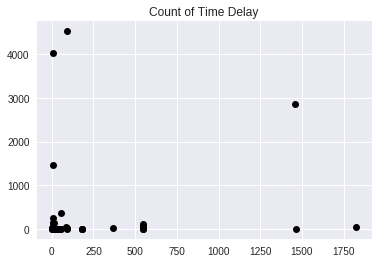

In [31]:
#Count of Time Delay In Days (expected time vs. requestedtime)
requestsDataFrame['TimeDelay'] = requestsDataFrame['expected_datetime']-requestsDataFrame['requested_datetime']
requestsDataFrame['TimeDelay'] = requestsDataFrame['TimeDelay'].dt.days
TimeDelay = pd.DataFrame(requestsDataFrame.groupby(['TimeDelay'])['TimeDelay'].agg(len))

fig, ax = plt.subplots()
ax.plot(TimeDelay['TimeDelay'].index, TimeDelay['TimeDelay'].values,'o', color='black')
ax.set_title('Count of Time Delay')

In [29]:
#Expected Number of Days To Complete
pd.DataFrame(requestsDataFrame.groupby('service_name')['TimeDelay'].agg("mean"))

,TimeDelay
service_name,
Bridge - Graffiti Complaint,53.100287
Graffiti,8.387736
Litter / Bin / Graffiti on Bin,13.318182
Road - Graffiti Complaint,34.189189
Road - Pot hole,419.511185
Sidewalk - Graffiti Complaint,33.169014


In [49]:
#Expected Number of Days To Complete (Closed Only)
pd.DataFrame(requestsDataFrame[requestsDataFrame["status"] == "closed"].groupby('service_name')['TimeDelay'].agg("mean"))

,TimeDelay
service_name,
Bridge - Graffiti Complaint,53.100287
Graffiti,8.382663
Litter / Bin / Graffiti on Bin,13.318182
Road - Graffiti Complaint,34.189189
Road - Pot hole,409.549598
Sidewalk - Graffiti Complaint,31.931655


In [48]:
#Expected Number of Days To Complete (Open Only)
pd.DataFrame(requestsDataFrame[requestsDataFrame["status"] == "open"].groupby('service_name')['TimeDelay'].agg("mean"))

,TimeDelay
service_name,
Graffiti,8.718750
Road - Pot hole,1090.791667
Sidewalk - Graffiti Complaint,90.500000


In [24]:
#log and lat and then comapre log/lat to time delay

In [25]:
#map first point
points = requestsDataFrame[['lat', 'long']].as_matrix()
m = folium.Map([points[:, 0].mean(), points[:, 1].mean()], zoom_start=11)
m.add_child(plugins.HeatMap(points, radius=15))
m